# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [290]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
# % matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [291]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


lets have a look at the raw data

In [231]:
portfolio['duration'] = portfolio['duration']*24 #make duration in hours to match transaction table later
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,72,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5


lets have a look at profile data frame

In [232]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [233]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [234]:
profile.id = profile.id.apply(str) #convert to non unicode strings

In [235]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


gender and income seem to have a lot of blank values, this might be worth looking at regarding features. maybe people who do not like to give gender or income have certain tendencies. obviously age==118 correlates with gender=None and Income None

lets split became_member_on into year,month,day columns

In [236]:
def int_date_to_YMD(integer_date_YMD):
    date_string = str(integer_date_YMD)
    return date_string[:4], date_string[4:6], date_string[6:]

In [237]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


maximum and average seem to tend a bit high, something worth looking at in a distribution

(array([1308., 1438., 2054., 3383., 3257., 2031.,  966.,  361.,   27.,
        2175.]),
 array([ 18.,  28.,  38.,  48.,  58.,  68.,  78.,  88.,  98., 108., 118.]),
 <a list of 10 Patch objects>)

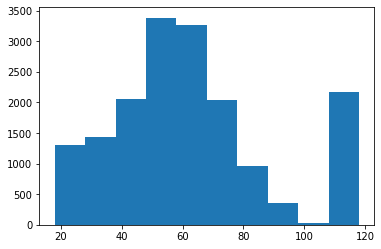

In [238]:
plt.hist(profile.age)

the average of age looks quite high for starbucks customers and the max age is probably outliers which need to be taken care of in either removing or guessing whether they substitute some other value.
first approach lets remove 118

In [239]:
profile = profile[profile.age!=118]

In [240]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [241]:
(profile.id.value_counts()>1).any()

False

checking for double ids in dataset - obviously none

(array([1731., 1707., 2234., 2210., 2345., 1435., 1215.,  990.,  498.,
         460.]),
 array([ 30000.,  39000.,  48000.,  57000.,  66000.,  75000.,  84000.,
         93000., 102000., 111000., 120000.]),
 <a list of 10 Patch objects>)

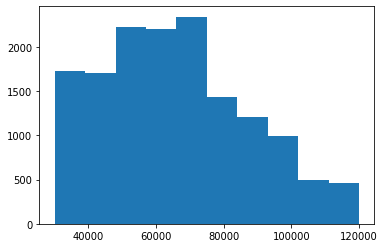

In [242]:
plt.hist(profile.dropna()['income'])

now a look onto transcript

In [243]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [244]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [245]:
transcript.iloc[24532]

person                     94de646f7b6041228ca7dec82adb97d2
event                                       offer completed
value     {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
time                                                     30
Name: 24532, dtype: object

the value column contains nested information, we should split it up into separate columns

In [246]:
possible_keys = transcript['value'].apply(lambda x: str(list(x.keys())))
possible_keys.value_counts()

['amount']                138953
['offer id']              134002
['offer_id', 'reward']     33579
Name: value, dtype: int64

In [247]:
[str(item) for item in list(transcript.event.unique())] #look at the unique non unicode strings

['offer received', 'offer viewed', 'transaction', 'offer completed']

create separate columns for offer id, amount and reward

In [248]:
transcript['offer_id'] = transcript.value.apply(lambda x: list(x.values())[0] if 'offer' in str(list(x.keys())[0]) else None)
transcript['amount'] = transcript.value.apply(lambda x: list(x.values())[0] if (list(x.keys())[0])==u'amount' else None)
transcript['reward'] = transcript.value.apply(lambda x: list(x.values())[1] if len(x.keys())==2 else None)
transcript.drop('value',axis=1,inplace=True)

unfortunately there is no information in the transcript table about when an informational offer is completed. for a compensation we will proceed as follows. 
- so far for all other offers there is a **offer received**, **offer viewed** and **offer completed** entry. we will enrich the table by a calculated completion row for valid data points of informational offer completed
- first we sort the data frame for person and continue to work on a copy - adding some helper columns as offer_type
- excluding the rows we dont need for computation: only keep transactions and informational offers viewed
- by shifting event and person columns we make sure we only process rows that belong together. we compare the shifted rows with the original entries in a row and decide whether a record is to be kept or not
- by logical combination of the keep_* columns we have created a criteria a data frame that holds an informational offer followed by the nearest transaction
- we replace **transaction** in the event column by **offer_id** from the previous row to match the row entries from the original transcript table
- now we will check if the time of the nearest transaction is still within the duration period allowed for the informational offer
- setting **amount** and **offer_type** colmn to **np.nan** and **informational** resectively to match the original transcript table format
- reducint the amount of columns to the ones necessary

In [249]:
def lookup_dictionary(look_up_df,search, result):
    '''
    function to create a lookup dictionary between search and result for example offer id -> offer type
    
    '''
    temp_df = look_up_df.copy()
    dic= dict(zip(temp_df[search],temp_df[result]))
    dic[None] = None
    return dic

create a dictionary that holds the information necessary for translating an offer id to an offer type

In [250]:
look_up_offer_type = lookup_dictionary(portfolio,'id','offer_type' )

In [251]:
transcript.sort_values(['person','time'],inplace=True)
trans = transcript.copy()

# create new column offer_type
trans['offer_type'] = trans['offer_id'].apply(lambda x:look_up_offer_type[x]) 

# select only rows with informational offers or transactions
trans = trans[(trans['offer_type']=='informational')|(trans['offer_type'].isnull())].copy()
print(len(trans))

# 
# trans = trans[(trans['event']=='offer received')|(trans['event']=='offer viewed')|(trans['event']=='transaction')]
# print(len(trans))

# by the following shifting operations we create a dataset that contains only an alternation of transactions and the corresponding offer views of informational offers
trans['keep_trans'] = (trans['event']=='transaction') & (trans['event'].shift(1)=='offer viewed') & (trans['person']==trans['person'].shift(1))
trans['keep_offer'] = (trans['event']=='offer viewed') & (trans['event'].shift(-1)=='transaction') & (trans['person']==trans['person'].shift(-1))
# trans['person_shift'] = trans['person'].shift(-1)
trans = trans[trans['keep_trans'] | trans['keep_offer']]

trans.loc[trans['offer_id'].isnull(),'offer_id'] = trans['offer_id'].shift(1)

165019


In [252]:
manual = 1
hrs_to_complete_informational_offer = 48

if manual:
    duration = hrs_to_complete_informational_offer
else:
    duration = trans['offer_id'].apply(lambda x: lookup_duration[x])

check if time between offer received and transaction completed is within duration  
a time can be set as default from the portolio data frame corresponding to each informational offer or chosen manually. 

In [253]:
trans

,person,event,time,offer_id,amount,reward,offer_type,keep_trans,keep_offer
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational,False,True
89291,0009655768c64bdeb2e877511632db8f,transaction,228,5a8bc65990b245e5a138643cd4eb9837,22.16,NaN,None,True,False
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational,False,True
168412,0009655768c64bdeb2e877511632db8f,transaction,414,3f207df678b143eea3cee63160fa8bed,8.57,NaN,None,True,False
16179,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,6,3f207df678b143eea3cee63160fa8bed,NaN,NaN,informational,False,True
...,...,...,...,...,...,...,...,...,...
294474,fff0f0aac6c547b9b263080f09a5586a,transaction,660,3f207df678b143eea3cee63160fa8bed,17.10,NaN,None,True,False
233587,fff3ba4757bd42088c044ca26d73817a,offer viewed,540,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational,False,True
233588,fff3ba4757bd42088c044ca26d73817a,transaction,540,5a8bc65990b245e5a138643cd4eb9837,388.22,NaN,None,True,False
65899,fffad4f4828548d1b5583907f2e9906b,offer viewed,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,informational,False,True


In [254]:
lookup_duration = lookup_dictionary(portfolio,'id','duration')

# create a column for the durations that apply to an offer - either manually assigned or by the portfolio dataset
trans['duration'] = duration

# bringing the time of the nearest transaction up to the corresponding offer viewed status
trans['time_pot_complete'] = trans['time'].shift(-1)

# calculations for determining if the nearest transaction was within a valid offer period
trans['within_time'] = (trans['time'] - trans['time_pot_complete'])<=trans['duration']
trans = trans[(trans['event']=='transaction') & (trans['within_time']==True)].copy()

# setting values to default
trans['amount'] = np.nan
trans['reward'] = 0
trans['offer_type'] = np.nan

# having all computations finished we can add the label offer completed as it is available for the other offer types as well
trans['event'] = 'offer completed'

# only keep the relevant columns
informal_transaction_to_offer_completed = trans[['person','event','time','offer_id','amount','reward','offer_type']]

In [255]:
# joining the original transcript data with the newly generated data regarding informational offers 
transcript = pd.concat([transcript,informal_transaction_to_offer_completed],axis=0)
transcript.sort_values(['time','person','amount'],inplace=True)
transcript.head()

,person,event,time,offer_id,amount,reward,offer_type
3066,0011e0d4e6b944f998e987f904e8c1e5,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
1889,0020c2b971eb4e9188eac86d93036a77,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
2652,003d66b6608740288d6cc97a6903f4f0,offer received,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
8354,00426fe3ffde4c6b9cb9ad6d077a13ea,offer received,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
9960,005500a7188546ff8a767329a2f7c76a,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN,NaN


check, what are customers with a high order behaviour

In [256]:
multi_order = transcript.groupby('person').count()
multi_order.sort_values('event',ascending=False,inplace=True)
multi_order.head()

,event,time,offer_id,amount,reward,offer_type
person,,,,,,
94de646f7b6041228ca7dec82adb97d2,51,51,16,35,5,0
8dbfa485249f409aa223a2130f40634a,49,49,13,36,3,0
d0a80415b84c4df4908b8403b19765e3,48,48,18,30,6,0
79d9d4f86aca4bed9290350fb43817c2,48,48,12,36,4,0
5e60c6aa3b834e44b822ea43a3efea26,48,48,16,32,5,0


chose a sample customer for looking into one example behaviour

In [257]:
example_customer = multi_order.index[0]
transcript[transcript['person']==example_customer]

,person,event,time,offer_id,amount,reward,offer_type
2276,94de646f7b6041228ca7dec82adb97d2,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
16010,94de646f7b6041228ca7dec82adb97d2,offer viewed,6,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
24531,94de646f7b6041228ca7dec82adb97d2,transaction,30,None,7.41,NaN,NaN
24532,94de646f7b6041228ca7dec82adb97d2,offer completed,30,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,NaN
42252,94de646f7b6041228ca7dec82adb97d2,transaction,102,None,1.47,NaN,NaN
55475,94de646f7b6041228ca7dec82adb97d2,offer received,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
75256,94de646f7b6041228ca7dec82adb97d2,offer viewed,186,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
77624,94de646f7b6041228ca7dec82adb97d2,transaction,192,None,2.62,NaN,NaN
81725,94de646f7b6041228ca7dec82adb97d2,transaction,204,None,0.59,NaN,NaN
93913,94de646f7b6041228ca7dec82adb97d2,transaction,246,None,2.28,NaN,NaN


create a temporary dataframe containing all times of **offer received** and **offer viewed**. this will be usefull for feature engineering. Due to the merge there will be data in the result where **offer viewed** will be before **offer received**. these must be removed. once this is done removing duplicate values in the time received column will make sure only adjacent events of offer received and offer viewed are counted into one event

In [258]:
df_temp_view = pd.merge(transcript[transcript['event'] == 'offer received'][['person', 'offer_id', 'time']],
                 transcript[transcript['event'] == 'offer viewed'][['person', 'offer_id', 'time']],
                 on=['person', 'offer_id'], how='left', suffixes=['_received', '_viewed'])

#keep entries that are equal meaning the customer checked the offer quite quickly
df_temp_view = df_temp_view[~(df_temp_view['time_viewed'] < df_temp_view['time_received'])] 

# now that all values are removed where time viewed is smaller than time received duplicates can be removed
df_temp_view.drop_duplicates(['person','offer_id','time_received'],keep='first',inplace=True)

# this handles the edgecase where a new offer is received and viewed and an older offer of the same type has never been viewed
# nevertheless it can still happen that an offer is viewed very long after having it received
df_temp_view.drop_duplicates(['person','offer_id','time_viewed'],keep='last',inplace=True) 

In [259]:
df_temp_view[df_temp_view['time_viewed']<df_temp_view['time_received']]

,person,offer_id,time_received,time_viewed


<- no inconsistancies

the same approach as before is chosen for creating a dataset considerung the time of offer completed and the reward information

In [260]:
df_temp_completed =  pd.merge(transcript[transcript['event'] == 'offer received'][['person', 'offer_id', 'time']],
                 transcript[transcript['event'] == 'offer completed'][['person', 'offer_id', 'time','reward']],
                 on=['person', 'offer_id'], how='left', suffixes=['_received', '_completed'])


df_temp_completed = df_temp_completed[~(df_temp_completed['time_completed'] < df_temp_completed['time_received'])] #keep entries that are equal meaning the customer checked the offer quite quickly
df_temp_completed.drop_duplicates(['person','offer_id','time_received'],keep='first',inplace=True) # now that all values are removed where time viewed is smaller than time received duplicates can be removed

# df_sample = df_temp_completed[df_temp_completed['person']==example_customer].copy()
# df_sample
df_temp_completed.drop_duplicates(['person','offer_id','time_completed'],keep='last',inplace=True) 

In [261]:
df_temp_completed[df_temp_completed['time_completed']<df_temp_completed['time_received']]

,person,offer_id,time_received,time_completed,reward


<- no inconsistancies
now the newly created temporary frames will be merged

In [262]:
customer_offers = pd.merge(df_temp_view,
                           df_temp_completed,
                          on=['person','offer_id','time_received'],
                          how='left')

last check needs to be, whether there are data which have a time completed being smaller time viewed. as expected there are data where the customer completes the offer but has never viewed it.

In [293]:
customer_offers.sort_values('person')

,person,offer_id,time_received,time_viewed,time_completed,reward,delta_viewed_received,delta_completed_received,delta_completed_viewed,offer_type
11823,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,228.0,0.0,24.0,60.0,36.0,informational
23731,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,NaN,NaN,36.0,NaN,NaN,informational
35403,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,456.0,NaN,5.0,48.0,NaN,NaN,bogo
47465,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,540.0,NaN,2.0,36.0,NaN,NaN,discount
59475,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,NaN,576.0,2.0,NaN,0.0,NaN,discount
...,...,...,...,...,...,...,...,...,...,...
35402,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,336,354.0,384.0,2.0,18.0,48.0,30.0,discount
59474,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,534.0,NaN,5.0,30.0,NaN,NaN,bogo
11822,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,0,6.0,60.0,2.0,6.0,60.0,54.0,discount
47464,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,408,414.0,414.0,2.0,6.0,6.0,0.0,discount


In [263]:
#to later also use the informational offers as possible features we assume, as stated in the task, that a customer is influenced by the information for the duration time given in the portfolio dataset for each informational offer after he or she has *received* the offer. i add that he can only be influenced if he saw the offer which leads to the following processing

# if the time viewed is larger than time completed the customer cannot have been influenced by the info offer thus will be have a time completed set to nan
customer_offers.loc[(customer_offers['time_completed'] < customer_offers['time_viewed']),'time_completed'] = None 

information_offers = [str(x) for x in list(portfolio[portfolio['offer_type']=='informational']['id'])]
information_offers
for offer_id in information_offers: #two informational offers are present in portfolio
    
#     # now if the time viewed is larger than time completed the customer cannot have been influenced by the info offer thus will be have a time completed set to nan
#     customer_offers.loc[(customer_offers['offer_id']==offer_id) & (customer_offers['time_completed'] < customer_offers['time_viewed']),'time_completed'] = None   
    
    #the reward is generally 0 on info offers but should be nan if there was not even a view or a view after the validity 
    customer_offers.loc[customer_offers['offer_id']==offer_id,'reward'] = 0 * customer_offers['time_completed'] #keeping nan as nan and others to 0

now we have a dataframe that holds information about the behaviour of one customer regarding the offers he or she made. we have listed the time stamps when he or she received,viewed or completed the offer

creating further information: here we calculate the deltas bewtween times

In [264]:
customer_offers['delta_viewed_received'] = customer_offers['time_viewed'] - customer_offers['time_received']
customer_offers['delta_completed_received'] = customer_offers['time_completed'] - customer_offers['time_received']
customer_offers['delta_completed_viewed'] = customer_offers['time_completed'] - customer_offers['time_viewed']

looking into one specific customer the values seem plausible. one can see interesting cases
- first row shows the infomation offer (reward == 0)
- second row has a regular offer with reward
- third row shows the case where the offer was read after completion only

In [265]:
sample2 = customer_offers[customer_offers['person']=='a5a6ef2b78a04ddc9f374dd7c7f60bff'].copy()
sample2

,person,offer_id,time_received,time_viewed,time_completed,reward,delta_viewed_received,delta_completed_received,delta_completed_viewed
7715,a5a6ef2b78a04ddc9f374dd7c7f60bff,5a8bc65990b245e5a138643cd4eb9837,0,6.0,24.0,0.0,6.0,24.0,18.0
43297,a5a6ef2b78a04ddc9f374dd7c7f60bff,2906b810c7d4411798c6938adc9daaa5,408,414.0,420.0,2.0,6.0,12.0,6.0
55341,a5a6ef2b78a04ddc9f374dd7c7f60bff,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,534.0,NaN,5.0,30.0,NaN,NaN


following data frame ```customer_offers``` represents how much time a person took to view or complete offers. if similar offers were sent to the same person it is the sum of times spent. for this we pivot the table for person in rows and offers in columns

In [266]:
offer_times_pivot = pd.pivot_table(customer_offers, index=['person'], columns=['offer_id'], aggfunc='mean')
offer_times_pivot.columns = offer_times_pivot.columns.swaplevel(0,1)
offer_times_pivot.sort_index(level=0,axis=1,inplace=True)
#customer_offers_pivot=customer_offers_pivot.droplevel(0,axis=1)
offer_times_pivot.head()

offer_id                         0b1e1539f2cc45b7b9fa7c272da2e1d7  \
                                         delta_completed_received   
person                                                              
0009655768c64bdeb2e877511632db8f                              NaN   
00116118485d4dfda04fdbaba9a87b5c                              NaN   
0011e0d4e6b944f998e987f904e8c1e5                            168.0   
0020c2b971eb4e9188eac86d93036a77                              NaN   
0020ccbbb6d84e358d3414a3ff76cffd                              NaN   

offer_id                                                                       \
                                 delta_completed_viewed delta_viewed_received   
person                                                                          
0009655768c64bdeb2e877511632db8f                    NaN                   NaN   
00116118485d4dfda04fdbaba9a87b5c                    NaN                   NaN   
0011e0d4e6b944f998e987f904e8c1e5                  144.0                  24.0   
0020c2b971eb4e9188eac86d93036a77                    NaN                   NaN   
0020ccbbb6d84e358d3414a3ff76cffd                    NaN                   NaN   

offer_id                                                              \
                                 reward time_completed time_received   
person                                                                 
0009655768c64bdeb2e877511632db8f    NaN            NaN           NaN   
00116118485d4dfda04fdbaba9a87b5c    NaN            NaN           NaN   
0011e0d4e6b944f998e987f904e8c1e5    5.0          576.0         408.0   
0020c2b971eb4e9188eac86d93036a77    NaN            NaN           NaN   
0020ccbbb6d84e358d3414a3ff76cffd    NaN            NaN           NaN   

offer_id                                     2298d6c36e964ae4a3e7e9706d1fb8c2  \
                                 time_viewed         delta_completed_received   
person                                                                          
0009655768c64bdeb2e877511632db8f         NaN                              NaN   
00116118485d4dfda04fdbaba9a87b5c         NaN                              NaN   
0011e0d4e6b944f998e987f904e8c1e5       432.0                             84.0   
0020c2b971eb4e9188eac86d93036a77         NaN                              NaN   
0020ccbbb6d84e358d3414a3ff76cffd         NaN                             54.0   

offer_id                                                                       \
                                 delta_completed_viewed delta_viewed_received   
person                                                                          
0009655768c64bdeb2e877511632db8f                    NaN                   NaN   
00116118485d4dfda04fdbaba9a87b5c                    NaN                   NaN   
0011e0d4e6b944f998e987f904e8c1e5                   66.0                  18.0   
0020c2b971eb4e9188eac86d93036a77                    NaN                   NaN   
0020ccbbb6d84e358d3414a3ff76cffd                   54.0                   0.0   

offer_id                          ... f19421c1d4aa40978ebb69ca19b0e20d  \
                                  ...                   time_completed   
person                            ...                                    
0009655768c64bdeb2e877511632db8f  ...                              NaN   
00116118485d4dfda04fdbaba9a87b5c  ...                              NaN   
0011e0d4e6b944f998e987f904e8c1e5  ...                              NaN   
0020c2b971eb4e9188eac86d93036a77  ...                              NaN   
0020ccbbb6d84e358d3414a3ff76cffd  ...                            378.0   

offer_id                                                    \
                                 time_received time_viewed   
person                                                       
0009655768c64bdeb2e877511632db8f         408.0       456.0   
00116118485d4dfda04fdbaba9a87b5c         372.0       423.0   
0011e0d4e6b944f998e9

one more feature could be, how much money a person spent after he or she saw the offer until completing the offer

In [267]:
customer_offers['offer_type'] = customer_offers['offer_id'].apply(lambda x: look_up_offer_type[x])

now we can create a data frame with person in rows and their offer counts in columns. after pivoting this data frame we will be able to do peform feature extraction

In [268]:
# aggregation of the customer_offers data frame to receive only one data frame that has persons in rows and aggregated values in the cells - sums for awards
# or count bogo for the number of bogo offers
offer_counts = customer_offers.groupby(['person','offer_type']).agg({'time_received':'count',
                             'time_viewed':'count',
                              'time_completed':'count',
                             'reward':'sum'}).rename(columns={'time_received':'count_received',
                                                              'time_viewed':'count_viewed',
                                                              'time_completed':'count_completed',
                                                              'reward':'sum_reward'})

offer_counts_pivot = pd.pivot_table(offer_counts,index='person', columns='offer_type',values=['count_received','count_viewed','count_completed','sum_reward'])

# cleanup of column names after transformation
offer_counts_pivot.columns = offer_counts_pivot.columns.swaplevel(0,1)
offer_counts_pivot.sort_index(level=0,axis=1,inplace=True)
offer_counts_pivot.fillna(value=0,inplace=True)
offer_counts_pivot.columns.set_levels(['bogo','discount','informational'],level=0,inplace=True)
offer_counts_pivot.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in offer_counts_pivot.columns] # make one word column header
offer_counts_pivot

,bogo_count_completed,bogo_count_received,bogo_count_viewed,bogo_sum_reward,discount_count_completed,discount_count_received,discount_count_viewed,discount_sum_reward,informational_count_completed,informational_count_received,informational_count_viewed,informational_sum_reward
person,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,1.0,1.0,5.0,1.0,2.0,1.0,4.0,1.0,2.0,2.0,0.0
00116118485d4dfda04fdbaba9a87b5c,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,1.0,5.0,2.0,2.0,2.0,8.0,2.0,2.0,2.0,0.0
0020c2b971eb4e9188eac86d93036a77,1.0,2.0,1.0,10.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0
0020ccbbb6d84e358d3414a3ff76cffd,2.0,2.0,2.0,10.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,0.0,1.0,1.0,5.0,1.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0
fff7576017104bcc8677a8d63322b5e1,1.0,3.0,2.0,5.0,2.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0
fff8957ea8b240a6b5e634b6ee8eafcf,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


analyzing the dataset one could see that offers do overlap - two offers can be started without the first one being completed. to not count amounts double douring that time, we identify overlapping offers and later remove them. 

In [269]:
def filter_time_range(df_ele,trange):
    if (df_ele['time']>=trange[0]) and (df_ele['time']<=trange[1]):
        return df_ele['amount']
    else:
        return np.nan

In [270]:
# sample_trans = transcript[transcript['person']=='0cc6e8553c844c02ab525bc466aa569b']
# sample =customer_offers[customer_offers['person']=='0cc6e8553c844c02ab525bc466aa569b']
# sub_group_ranges = list(zip(sample['time viewed'], sample['time completed']))

def overlap(sub_group_ranges):
    valid_ranges = []
    #print(sub_group_ranges)
    for tup in sub_group_ranges:
        if not (np.isnan(np.sum(tup))):
           # print(np.sum(tup))
            valid_ranges.append(tup)
        #    sub_group_ranges.remove(tup)
   # print(valid_ranges)        
    tuple_list =[] 
    if len(valid_ranges)>0:
        for tup in valid_ranges:
            tuple_list.append(np.arange(tup[0],tup[1]))
    
    if len(tuple_list)>0:
        xs = set(tuple_list[0])
        count = len(tuple_list[0])
        for item in tuple_list[1:]:
            xs = xs.union(item)
            count = count + len(item)
    else:
        count = 0
        xs = set()
    if len(xs) < count:
        return 1
    else:
        return 0

In [271]:
%%time
file_name = 'df_person_money_spent_inc_overlap_informational_retry.pkl'
sub_group_ranges=None
collected_sub_group_ranges = None
#df_person_money_spent=None
if os.path.isfile(file_name):
    df_person_money_spent = pd.read_pickle(file_name)
    print('read file {}'.format(file_name))
else:
    person_list =list(transcript.groupby('person').count().sort_values('event', ascending=False).index)[:]
    person_money_spent = []
    person_money_spent_per_offer=[]
    overlap_list=[]
    for i, person in enumerate(person_list):
        df_offer = pd.DataFrame()
        if i%100==0:
            print(i,' person evaluated')
        offer_list = [str(x) for x in list(transcript[transcript['person']==person]['offer_id'].unique())]
        if 'None' in offer_list : offer_list.remove('None')
        person_money_spent_per_offer=[]
        collected_sub_group_ranges=[]
        for offer_id in offer_list:
           # print(offer_id)
            df = transcript.loc[transcript['person']==person].copy()
            sample = customer_offers.loc[(customer_offers['person']==person) & (customer_offers['offer_id']==offer_id)]
            sub_group_ranges = list(zip(sample['time_viewed'], sample['time_completed']))
            collected_sub_group_ranges = collected_sub_group_ranges+sub_group_ranges
            for trange in sub_group_ranges:
                df[str(trange)] = df.apply(lambda x: filter_time_range(x,trange),axis=1)
            dfg_per_offer=df.groupby(['person']).sum()
            sub_result = pd.concat([dfg_per_offer.iloc[:,:3],dfg_per_offer.iloc[:,3:].sum(axis=1)],axis=1)
            sub_result['offer_id'] = offer_id
            
            person_money_spent_per_offer.append(sub_result)
           # print(len(person_money_spent_per_offer))
        if len(offer_list) >0:
            df_person_money_spent_per_offer = pd.concat(person_money_spent_per_offer,axis=0)
            #print(collected_sub_group_ranges)
            overlap_status = overlap(collected_sub_group_ranges)
           # print('overlap: ',overlap_status)
            df_person_money_spent_per_offer['overlap'] = overlap_status
            person_money_spent.append(df_person_money_spent_per_offer)            
    df_person_money_spent = pd.concat(person_money_spent,axis=0)
    df_person_money_spent.rename(columns={0:'spent_in_offer'},inplace=True)
    df_person_money_spent.to_pickle(file_name)
    print('wrote file {}'.format(file_name))

read file df_person_money_spent_inc_overlap_informational_retry.pkl
CPU times: user 11.2 ms, sys: 7.71 ms, total: 18.9 ms
Wall time: 68.4 ms


some of the results overlap. this means that more than one offer is active per customer at the same time(viewed and not yet completed). since they are around 10 % of the data they will be excluded. otherwise the amount spent during an offer would be counted multiple times.

In [272]:
df_person_money_spent

,time,amount,reward,spent_in_offer,offer_id,overlap
person,,,,,,
94de646f7b6041228ca7dec82adb97d2,20586,90.23,22.0,7.41,f19421c1d4aa40978ebb69ca19b0e20d,0
94de646f7b6041228ca7dec82adb97d2,20586,90.23,22.0,30.84,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
94de646f7b6041228ca7dec82adb97d2,20586,90.23,22.0,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
94de646f7b6041228ca7dec82adb97d2,20586,90.23,22.0,11.01,fafdcd668e3743c1bb461111dcafc2a4,0
94de646f7b6041228ca7dec82adb97d2,20586,90.23,22.0,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,0
...,...,...,...,...,...,...
fccc9279ba56411f80ffe8ce7e0935cd,1038,0.00,0.0,0.00,2906b810c7d4411798c6938adc9daaa5,0
df9fc9a86ca84ef5aedde8925d5838ba,672,0.00,0.0,0.00,2906b810c7d4411798c6938adc9daaa5,0
df9fc9a86ca84ef5aedde8925d5838ba,672,0.00,0.0,0.00,3f207df678b143eea3cee63160fa8bed,0


In [273]:
len(df_person_money_spent[df_person_money_spent['overlap']==1])/len(df_person_money_spent)

0.0793989381873341

following data frame ```df_person_money_spent``` represents how much a single person spent while an offer was active. if similar offers were sent to the same person it is the sum of spendings. to group further we can pivot the table for person in rows and offers in columns or for a less deep analysis by only reward-type in columns

In [274]:
group_spending = ['offer_id']
group_spending = ['offer_type']
df_person_money_spent=df_person_money_spent[df_person_money_spent['overlap']==0].copy()
df_person_money_spent['offer_type'] = df_person_money_spent['offer_id'].apply(lambda x: look_up_offer_type[x])

df_person_money_spent_pivot = pd.pivot_table(df_person_money_spent, index=['person'], columns=group_spending, aggfunc={'spent_in_offer':'sum'})
df_person_money_spent_pivot.columns = df_person_money_spent_pivot.columns.swaplevel(0,1)
df_person_money_spent_pivot.sort_index(axis=1,  inplace=True)
df_person_money_spent_pivot.fillna(value=0,inplace=True)
# df_person_money_spent_pivot.columns.set_levels(['non rewarded','rewarded'],level=0,inplace=True)
df_person_money_spent_pivot.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in df_person_money_spent_pivot.columns]
#person_spendings_by_offer=df_person_money_spent_pivot.droplevel(0,axis=1)
df_person_money_spent_pivot

,bogo_spent_in_offer,discount_spent_in_offer,informational_spent_in_offer
person,,,
0009655768c64bdeb2e877511632db8f,0.00,0.00,22.16
00116118485d4dfda04fdbaba9a87b5c,0.00,0.00,0.00
0020c2b971eb4e9188eac86d93036a77,17.24,17.63,0.00
0020ccbbb6d84e358d3414a3ff76cffd,24.85,11.65,0.00
003d66b6608740288d6cc97a6903f4f0,0.00,22.47,0.44
...,...,...,...
fff3ba4757bd42088c044ca26d73817a,0.00,20.98,0.00
fff7576017104bcc8677a8d63322b5e1,0.00,21.63,0.00
fff8957ea8b240a6b5e634b6ee8eafcf,0.00,0.00,0.00


now we can start to build a data frame holding demographic data and data derrived from calculations on how much a customer spends regarding a certain offer
- taking the base profile dataset containing demographic information
- concatenating with information about spendings and rewards per offer
- concatenating with spendings and rewards in general

In [275]:
profile_for_merge = profile.copy()
profile_for_merge.index = profile_for_merge.id
profile_for_merge.drop('id',axis=1,inplace=True)
profile_for_merge

,gender,age,became_member_on,income
id,,,,
0610b486422d4921ae7d2bf64640c50b,F,55,20170715,112000.0
78afa995795e4d85b5d9ceeca43f5fef,F,75,20170509,100000.0
e2127556f4f64592b11af22de27a7932,M,68,20180426,70000.0
389bc3fa690240e798340f5a15918d5c,M,65,20180209,53000.0
2eeac8d8feae4a8cad5a6af0499a211d,M,58,20171111,51000.0
...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,F,45,20180604,54000.0
2cb4f97358b841b9a9773a7aa05a9d77,M,61,20180713,72000.0
01d26f638c274aa0b965d24cefe3183f,M,49,20170126,73000.0


In [276]:
amount_spent = transcript.groupby('person').agg({'amount':'sum'})
amount_spent.columns = ['amount_spent_total']

In [277]:
df_to_combine=[offer_counts_pivot,df_person_money_spent_pivot,amount_spent,profile_for_merge]
                   

joined_part1 = pd.merge(profile_for_merge, offer_counts_pivot, how='inner', left_index=True, right_index=True)
joined_part2 = pd.merge(joined_part1, df_person_money_spent_pivot, how='inner', left_index=True, right_index=True)
customers = pd.merge(joined_part2, amount_spent, how='inner', left_index=True, right_index=True)
customers.sort_index(axis=1,  inplace=True)

#joined = pd.concat(df_to_combine,axis=1, sort=False)
print([len(x) for x in df_to_combine]+[len(customers)])

[16994, 15776, 17000, 14825, 13680]


In [278]:
customers[customers.index.str.startswith('0cc6e8553c844c02ab525bc466aa569b')]

,age,amount_spent_total,became_member_on,bogo_count_completed,bogo_count_received,bogo_count_viewed,bogo_spent_in_offer,bogo_sum_reward,discount_count_completed,discount_count_received,discount_count_viewed,discount_spent_in_offer,discount_sum_reward,gender,income,informational_count_completed,informational_count_received,informational_count_viewed,informational_spent_in_offer,informational_sum_reward


In [279]:
customers.sort_values('bogo_spent_in_offer')

,age,amount_spent_total,became_member_on,bogo_count_completed,bogo_count_received,bogo_count_viewed,bogo_spent_in_offer,bogo_sum_reward,discount_count_completed,discount_count_received,discount_count_viewed,discount_spent_in_offer,discount_sum_reward,gender,income,informational_count_completed,informational_count_received,informational_count_viewed,informational_spent_in_offer,informational_sum_reward
0610b486422d4921ae7d2bf64640c50b,55,77.01,20170715,1.0,1.0,0.0,0.00,5.0,0.0,0.0,0.0,0.00,0.0,F,112000.0,0.0,1.0,0.0,0.00,0.0
aa8159bbe9134ccfb6d7807714c8ea19,78,47.07,20180319,0.0,2.0,2.0,0.00,0.0,1.0,2.0,2.0,12.41,2.0,M,52000.0,0.0,0.0,0.0,0.00,0.0
b1dbb320a2484f40824363fd4be52e1f,22,26.74,20171116,0.0,1.0,1.0,0.00,5.0,1.0,3.0,2.0,11.85,3.0,F,72000.0,0.0,0.0,0.0,0.00,0.0
7fb6bf3c081b41ceb3609d53c87110d7,65,24.96,20151016,0.0,2.0,2.0,0.00,0.0,0.0,2.0,0.0,0.00,0.0,M,33000.0,1.0,2.0,2.0,2.68,0.0
3095383d82d44cd1bbbdc09170c5b8ac,59,75.31,20180111,1.0,3.0,2.0,0.00,15.0,1.0,1.0,1.0,20.68,2.0,M,71000.0,0.0,1.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25adc7b5ab704fcc9f8777ed914234ff,75,931.81,20170809,2.0,2.0,2.0,835.23,10.0,1.0,1.0,0.0,0.00,5.0,M,92000.0,1.0,2.0,2.0,18.44,0.0
ff2113310abe4c6687569bdd8f028fe3,55,973.74,20170508,1.0,1.0,1.0,841.45,10.0,2.0,3.0,1.0,0.00,9.0,M,100000.0,0.0,0.0,0.0,0.00,0.0
a12fba072dae4e3aae2e1b4b92b92aa1,55,1011.82,20160420,1.0,1.0,1.0,871.51,10.0,1.0,3.0,1.0,0.00,4.0,F,97000.0,0.0,1.0,0.0,0.00,0.0
05bedc6bbcc64a41b1745f6efe00776d,70,1148.92,20150729,3.0,3.0,3.0,979.41,20.0,0.0,0.0,0.0,0.00,0.0,F,105000.0,0.0,2.0,2.0,0.00,0.0


In [280]:
customers.describe()

,age,amount_spent_total,became_member_on,bogo_count_completed,bogo_count_received,bogo_count_viewed,bogo_spent_in_offer,bogo_sum_reward,discount_count_completed,discount_count_received,discount_count_viewed,discount_spent_in_offer,discount_sum_reward,income,informational_count_completed,informational_count_received,informational_count_viewed,informational_spent_in_offer,informational_sum_reward
count,13680.000000,13680.000000,1.368000e+04,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.000000,13680.0
mean,54.207018,115.432002,2.016689e+07,0.786769,1.701096,1.463158,14.641263,6.895102,0.908772,1.641886,1.191447,15.162757,2.949561,65068.128655,0.252705,0.830848,0.618202,3.643816,0.0
std,17.475424,129.365489,1.187856e+04,0.913425,1.055614,1.044777,36.975843,7.965376,0.942229,1.024397,0.995773,35.795503,3.082452,21740.809658,0.501726,0.792380,0.755072,15.819206,0.0
min,18.000000,0.000000,2.013073e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,42.000000,29.220000,2.016052e+07,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,48000.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,55.000000,84.240000,2.017080e+07,1.000000,2.000000,1.000000,0.000000,5.000000,1.000000,2.000000,1.000000,7.075000,2.000000,63000.000000,0.000000,1.000000,0.000000,0.000000,0.0
75%,66.000000,160.732500,2.017123e+07,1.000000,2.000000,2.000000,21.810000,10.000000,1.000000,2.000000,2.000000,22.360000,5.000000,79000.000000,0.000000,1.000000,1.000000,0.000000,0.0
max,101.000000,1608.690000,2.018073e+07,5.000000,6.000000,6.000000,1015.730000,50.000000,5.000000,6.000000,6.000000,1033.780000,18.000000,120000.000000,5.000000,5.000000,5.000000,855.310000,0.0


In [281]:
customers.to_excel('customers.xlsx')
customers.to_csv('customers.csv')

## KPI s for person
Lets first grab a list of features that come to mind when wanting to analyze the customers behvaiour. 

- count offers received
- count offers viewed
- count transactions
- count offers completed
- total ammount spent
- view_ratio
- transaction_ratio
- completeness_ratio
- ammount spent during offer A
- ammount spent outside offer
- time being customer



checking conversion rate of each offer type

In [282]:
customers.columns

Index(['age', 'amount_spent_total', 'became_member_on', 'bogo_count_completed',
       'bogo_count_received', 'bogo_count_viewed', 'bogo_spent_in_offer',
       'bogo_sum_reward', 'discount_count_completed',
       'discount_count_received', 'discount_count_viewed',
       'discount_spent_in_offer', 'discount_sum_reward', 'gender', 'income',
       'informational_count_completed', 'informational_count_received',
       'informational_count_viewed', 'informational_spent_in_offer',
       'informational_sum_reward'],
      dtype='object')

In [283]:
cr_bogo = customers['bogo_count_completed'].sum()/customers['bogo_count_received'].sum()
cr_discount = customers['discount_count_completed'].sum()/customers['discount_count_received'].sum()
cr_information = customers['informational_count_completed'].sum()/customers['informational_count_received'].sum()
print(cr_bogo,cr_discount,cr_information)

0.4625069829401401 0.5534927207159076 0.304152736230864


the high conversion rate of informational offers might be due to the fact that the initial description of the dataset suggests that an informational offer influences the customer for its given duration. this might be too long and can be used as a parameter to tweak later. however the amount spent on informational offers is less then in rewarded offers - roughly half regarding the other offers individually

In [284]:
sum_bogo = customers['bogo_spent_in_offer'].sum()
sum_discount = customers['discount_spent_in_offer'].sum()
sum_information = customers['informational_spent_in_offer'].sum()
print(sum_bogo,sum_discount,sum_information)

200292.47999999998 207426.52 49847.399999999994


In [285]:
customers

,age,amount_spent_total,became_member_on,bogo_count_completed,bogo_count_received,bogo_count_viewed,bogo_spent_in_offer,bogo_sum_reward,discount_count_completed,discount_count_received,discount_count_viewed,discount_spent_in_offer,discount_sum_reward,gender,income,informational_count_completed,informational_count_received,informational_count_viewed,informational_spent_in_offer,informational_sum_reward
0610b486422d4921ae7d2bf64640c50b,55,77.01,20170715,1.0,1.0,0.0,0.00,5.0,0.0,0.0,0.0,0.00,0.0,F,112000.0,0.0,1.0,0.0,0.00,0.0
78afa995795e4d85b5d9ceeca43f5fef,75,159.27,20170509,2.0,3.0,3.0,41.61,20.0,0.0,0.0,0.0,0.00,0.0,F,100000.0,1.0,1.0,1.0,19.67,0.0
e2127556f4f64592b11af22de27a7932,68,57.73,20180426,1.0,1.0,1.0,18.42,5.0,1.0,2.0,2.0,18.42,2.0,M,70000.0,0.0,1.0,0.0,0.00,0.0
2eeac8d8feae4a8cad5a6af0499a211d,58,15.62,20171111,0.0,0.0,0.0,0.00,0.0,1.0,2.0,2.0,12.43,2.0,M,51000.0,0.0,1.0,0.0,0.00,0.0
aa4862eba776480b8bb9c68455b8c2e1,61,85.55,20170911,2.0,3.0,3.0,24.89,25.0,0.0,1.0,1.0,0.00,0.0,F,57000.0,1.0,1.0,1.0,15.95,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,45,20.03,20180604,0.0,1.0,1.0,0.00,0.0,0.0,1.0,1.0,0.00,0.0,F,54000.0,0.0,1.0,1.0,0.00,0.0
2cb4f97358b841b9a9773a7aa05a9d77,61,25.97,20180713,1.0,1.0,0.0,0.00,5.0,0.0,0.0,0.0,0.00,0.0,M,72000.0,1.0,2.0,1.0,2.93,0.0
01d26f638c274aa0b965d24cefe3183f,49,39.74,20170126,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,0.00,0.0,M,73000.0,0.0,2.0,1.0,0.00,0.0
9dc1421481194dcd9400aec7c9ae6366,83,189.67,20160307,1.0,3.0,3.0,20.24,25.0,0.0,0.0,0.0,0.00,0.0,F,50000.0,0.0,0.0,0.0,0.00,0.0


In [287]:
customers_bogo = customers[['age','gender','income','became_member_on','amount_spent_total','bogo_count_completed','bogo_count_received','bogo_count_viewed','bogo_spent_in_offer','bogo_sum_reward']]
customers_bogo.to_csv('customers_bogo.csv')

customers_discount = customers[['age','gender','income','became_member_on','amount_spent_total','discount_count_completed','discount_count_received','discount_count_viewed','discount_spent_in_offer','discount_sum_reward']]
customers_discount.to_csv('customers_discount.csv')

customers_informational = customers[['age','gender','income','became_member_on','amount_spent_total','informational_count_completed','informational_count_received','informational_count_viewed','informational_spent_in_offer','informational_sum_reward']]
customers_informational.to_csv('customers_informational.csv')

customers_separate_list = [customers_bogo, customers_discount,customers_informational]

In [289]:
profile

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0
